In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import collections
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, tnrange
import time
import os
import re
import spacy
import html

In [0]:
PATH = Path('data/imdb/')
os.makedirs(PATH, exist_ok=True)

In [0]:
!cd {PATH} && wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz && tar xf aclImdb_v1.tar.gz

In [0]:
!find {PATH}/aclImdb/train -name '*.txt' | xargs cat | wc -w
!find {PATH}/aclImdb/test -name '*.txt' | xargs cat | wc -w

17561580
5711719


In [0]:
TRN_PATH = PATH/'aclImdb/train'
VAL_PATH = PATH/'aclImdb/test'

### Tokenize & Numericalize

In [0]:
def read_text(path):
  subdir = ['pos', 'neg', 'unsup']
  txts = []
  for d in subdir:
    for o in (path/d).glob('*.*'):
      txts.append(open(o, encoding='utf-8').read())
  return np.array(txts)

In [0]:
trn_txts = read_text(TRN_PATH)
val_txts = read_text(VAL_PATH)
len(trn_txts), len(val_txts)

(75000, 25000)

In [0]:
txts = np.concatenate([trn_txts, val_txts])
df = pd.DataFrame({'text': txts})
print(len(df))
df.head()

100000


,text
0,This film is mesmerizing in its beauty and cre...
1,This is arguably John Thaw's finest performanc...
2,"Surprisingly good. The acting was fun, the scr..."
3,"As winter approaches, our state-owned broadcas..."
4,This film reminds me of 42nd Street starring B...


In [0]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('\n\n', '\n')
    return re1.sub(' ', html.unescape(x))

In [0]:
df.text = df.text.apply(fixup)
df.to_csv(PATH/'txts.csv', index=False, header=False)
del df, txts, trn_txts, val_txts

In [0]:
class Tokenizer():
  def __init__(self, lang='en'):
    self.tok = spacy.load(lang)
  
  def preprocess(self, x):
    ts = []
    TOK_UP = ' _tup_ '
    for w in re.findall(f'\w+|\W+', x):
      ts += [TOK_UP, w.lower()] if (w.isupper() and len(w) > 2) else [w.lower()]
    return ''.join(ts)
    
  def tokenize(self, x):
    if isinstance(x, (list, tuple, np.ndarray)):
      return [self.tokenize(o) for o in x]
    else:
      return [t.text for t in self.tok.tokenizer(self.preprocess(x))]
  
  @staticmethod
  def tokenize_mp(x, n_cpus=None, lang='en'):
#     pdb.set_trace()
    if isinstance(x, (np.ndarray, tuple)): x = list(x)
    elif not isinstance(x, list): x = [x]
    n_cpus = n_cpus or os.cpu_count()
    xs_l = (len(x) // n_cpus) + 1
    xs = [x[i:i+xs_l] for i in range(0, len(x), xs_l)]
    toks = []
    with ThreadPoolExecutor(n_cpus) as e:
      toks += sum(e.map(Tokenizer(lang).tokenize, xs), [])
    return toks
  
  @staticmethod
  def tokenize_df(dl, label, lang='en'):
    ts = []
    for i, df in enumerate(dl):
      print(i)
      ts += Tokenizer.tokenize_mp(df.iloc[:, label].values, lang=lang)
    return ts

In [0]:
chunksize = 25000
dl = pd.read_csv(PATH/'txts.csv', header=None, chunksize=chunksize)
ts = Tokenizer.tokenize_df(dl, 0)
np.array(ts).shape

0
1
2
3


(100000,)

In [0]:
trn_toks, val_toks = train_test_split(ts, test_size=0.1)
len(trn_toks), len(val_toks)

(90000, 10000)

In [0]:
np.save(PATH/'trn_toks.npy', trn_toks)
np.save(PATH/'val_toks.npy', val_toks)

In [0]:
freq = Counter(p for o in trn_toks for p in o)
freq.most_common(10)

[('the', 1209087),
 (',', 985669),
 ('.', 985505),
 ('and', 586703),
 ('a', 583814),
 ('of', 524925),
 ('to', 485277),
 ('is', 393949),
 ('it', 341966),
 ('in', 337928)]

In [0]:
vocab_size = 60000
min_freq = 4
itos = [n for n, v in freq.most_common(vocab_size) if v >= min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
np.save(PATH/'itos.npy', itos)
stoi = collections.defaultdict(lambda: 0, {o:i for i, o in enumerate(itos)})

In [0]:
trn_ds = [stoi[p] for o in trn_toks for p in o]
val_ds = [stoi[p] for o in val_toks for p in o]
np.save(PATH/'trn_ds.npy', trn_ds)
np.save(PATH/'val_ds.npy', val_ds)

### Dataset

In [0]:
trn_ds = np.load(PATH/'trn_ds.npy')
val_ds = np.load(PATH/'val_ds.npy')
itos = np.load(PATH/'itos.npy')
stoi = collections.defaultdict(lambda: 0, {o:i for i, o in enumerate(itos)})

In [0]:
class ModelDataloader():
  def __init__(self, nums, bs, bptt):
    self.bs, self.bptt = bs, bptt
    self.data = self.batchify(nums)
    self.n = self.data.size(0)
    
  def __len__(self):
    return self.n // self.bptt - 1
  
  def __iter__(self):
    self.i, self.iter = 0, 0
    return self
  
  def __next__(self):
    if self.i >= self.n - 1 or self.iter >= len(self): raise StopIteration
    seq_len = self.bptt if np.random.random() < 0.95 else self.bptt // 2
    seq_len = max(5, int(np.random.normal(seq_len, 5)))
    x, y = self.data[self.i:self.i+seq_len], self.data[self.i+1:self.i+1+seq_len]
    self.i += seq_len
    self.iter += 1
    return x, y.view(-1)
    
  def batchify(self, data):
    if isinstance(data, list): data = np.array(data)
    n = len(data) // self.bs
    data = torch.from_numpy(data[:n*self.bs])
    return data.view(self.bs, -1).t().contiguous().cuda()

In [0]:
# dl = ModelDataloader(nums, 64, 20)
# xs, y = next(iter(dl))
# xs.size(), y.size()

In [0]:
class ModelData():
  def __init__(self, vocab, bs, bptt, trn_ds, val_ds, test_ds=None):
    self.trn_ds, self.val_ds, self.test_ds = trn_ds, val_ds, test_ds
    self.vocab, self.n = vocab, len(vocab)
    self.trn_dl = ModelDataloader(self.trn_ds, bs, bptt)
    self.val_dl = ModelDataloader(self.val_ds, bs, bptt)
    self.test_dl = None if self.test_ds is None else ModelDataloader(self.test_ds, bs, bptt)

In [0]:
bs=64
bptt=70
md = ModelData(itos, bs, bptt, trn_ds, val_ds)
md.n, len(md.trn_dl), len(md.val_dl)

(58823, 5568, 617)

In [0]:
x, y = next(iter(md.trn_dl))
x.shape, y.shape, x, y

(torch.Size([67, 64]),
 torch.Size([4288]),
 tensor([[ 2999, 18364,    31,  ...,   802,   319,     5],
         [    0,   509,     5,  ...,    47,    11,   476],
         [    9,  3826,    14,  ...,     9,     6,   684],
         ...,
         [    9,    73, 19803,  ..., 12141,   344,   422],
         [   61,   163,    58,  ...,     5,     8,     3],
         [   27,   507,   124,  ...,  3626,   780,     5]], device='cuda:0'),
 tensor([  0, 509,   5,  ..., 317,  23, 257], device='cuda:0'))

### RNN

In [0]:
vocab_size = md.n
emb_nf = 200
nf = 256

In [0]:
class CharRNN(nn.Module):
  def __init__(self, vocab_size, emb_nf, nf):
    super().__init__()
    self.vocab_size = vocab_size
    self.emb = nn.Embedding(vocab_size, emb_nf)
    self.i_h = nn.Linear(emb_nf, nf)
    self.rnn = nn.RNN(nf, nf)
    self.h_o = nn.Linear(nf, vocab_size)
    self.h = torch.zeros(1, bs, nf).cuda()
    self.tanh = nn.Tanh()
    
  def forward(self, x):
    x = self.tanh(self.i_h(self.emb(x)))
    o, h = self.rnn(x, self.h)
    self.h = h.detach()
    return F.log_softmax(self.h_o(o), -1).view(-1, self.vocab_size)

In [0]:
m = CharRNN(vocab_size, emb_nf, nf).cuda()

In [0]:
x, y = next(iter(md.trn_dl))
preds = m(x)
preds.shape, y.shape

(torch.Size([4224, 58823]), torch.Size([4224]))

In [0]:
def get_trainable_parameters(m): return [p for p in m.parameters() if p.requires_grad]


class Stepper():
  def __init__(self, model, opt, crit, clip):
    self.m, self.opt, self.crit, self.clip = model, opt, crit, clip
    self.reset()
    
  def reset(self, train=True):
    if train: self.m.train()
    else: self.m.eval()
    if hasattr(self.m, 'reset'):
      self.m.reset()
  
  def step(self, xs, y):
    preds = self.m(xs)
    loss = self.crit(preds, y)
    self.opt.zero_grad()
    loss.backward()
    if self.clip: nn.utils.clip_grad_norm_(get_trainable_parameters(m), self.clip)
    # weight decay  
    if 'wd' in self.opt.param_groups[0] and self.opt.param_groups[0]['wd'] != 0:
      for pg in self.opt.param_groups:
        lr, wd = pg['lr'], pg['wd']
        for p in pg['params']:
          if p.grad is not None:
            p.data.add_(-(lr * wd))
    self.opt.step()
    return loss.data.item()
  
  def validate(self, xs, y):
    preds = self.m(xs)
    return preds, self.crit(preds, y).data.item()
  

def validate(stepper, dl, metrics):
  losses, metric_vals = [], []
  stepper.reset(False)
  with torch.no_grad():
    t = tqdm(iter(dl), leave=False, total=len(dl), miniters=0)
    for xs, y in t:
      preds, loss = stepper.validate(xs, y)
      t.set_postfix(loss=loss, refresh=False)
      losses.append(loss)
      v = [f(preds, y) for f in metrics]
      if len(v): metric_vals.append(v)
    t.close()
  if len(metric_vals): metric_vals = list(np.mean(np.stack(metric_vals), 0))
  return [np.mean(losses)] + metric_vals

In [0]:
def fit(model, data, epochs, opt, crit, clip=0., metrics=None):
  metrics = metrics or []
  stepper = Stepper(model, opt, crit, clip=clip)
  title_printed = False
  
  for ep in tnrange(epochs, desc='Epochs'):
    names = ['epoch', 'trn_loss', 'val_loss'] + [m.__name__ for m in metrics]
    fmt = '{!s:^15}' + ' {!s:10}' * (len(names) - 1)

    # train
    t = tqdm(iter(data.trn_dl), leave=False, total=len(data.trn_dl), miniters=0)
    for xs, y in t:
      loss = stepper.step(xs, y)
      t.set_postfix(loss=loss, refresh=False)
    t.close()

    # validation
    values = validate(stepper, data.val_dl, metrics)
    
    # show results
    values.insert(0, loss)
    if title_printed == False:
      print(fmt.format(*names))
      title_printed = True
    values = np.round([o for o in values], 6)
    print(fmt.format(*([ep] + list(values))))

In [0]:
opt = optim.Adam(m.parameters(), lr=1e-3)

In [0]:
fit(m, md, 1, opt, F.nll_loss)

     epoch      trn_loss   val_loss  
       0        4.882467   4.941533  



### SGDR: Cosine Annealing and Warm Restart

In [0]:
class Callback():
  def __init__(self): pass
  def on_train_begin(self): pass
  def on_train_end(self): pass
  def on_cycle_begin(self): pass
  def on_cycle_end(self): pass
  def on_epoch_begin(self): pass
  def on_epoch_end(self, metrics): pass
  def on_batch_begin(self): pass
  def on_batch_end(self, metrics): pass

class LossRecorder(Callback):
  def __init__(self, opt, record_mom=False):
    self.opt, self.record_mom = opt, record_mom
    self.lr = opt.param_groups[0]['lr']
    if record_mom: self.mom = opt.param_groups[0]['momentum']

  def on_train_begin(self):
    self.iter, self.epoch = 0, 0
    self.iters, self.epochs, self.times = [], [], []
    self.lrs, self.losses, self.val_losses, self.metrics = [], [], [], []
    if self.record_mom: self.moms = []
    self.start = time.time()

  def on_batch_end(self, loss):
    self.iter += 1
    self.iters.append(self.iter)
    self.lrs.append(self.lr)
    self.losses.append(loss)
    if self.record_mom: self.moms.append(self.mom)
  
  def op_epoch_end(self, metrics):
    self.epoch += 1
    self.epochs.append(self.iter)
    self.times.append(time.time() - self.start)
    self.save_metrics(metrics)
    
  def save_metrics(self, values):
    self.val_losses.append(values[0])
    if len(values[1:]) > 2:
      self.metrics.append(values[1:])
    elif len(values[1:]) == 2:
      self.metrics.append(values[1])
      
  def plot_loss(self, n_skip=10, n_skip_end=5):
    plt.plot(self.iters[n_skip:-n_skip_end], self.losses[n_skip:-n_skip_end])
    plt.xlabel('iterations')
    plt.ylabel('train losses')

  def plot_lr(self):
    if self.record_mom:
      fig, axes = plt.subplots(1, 2, figsize=(12, 8))
      axes[0].set_xlabel('iterations')
      axes[0].set_ylabel('learning rates')
      axes[1].set_xlabel('iterations')
      axes[1].set_ylabel('momentums')
      axes[0].plot(self.iters, self.lrs)
      axes[1].plot(self.iters, self.moms)
    else:
      plt.plot(self.iters, self.lrs)
      plt.xlabel('iterations')
      plt.ylabel('learning rates')

In [0]:
class LRUpdater(LossRecorder):
  def __init__(self, opt, **kwargs):
    super().__init__(opt, **kwargs)
    self.initial_lr = self.lr
    
  def on_cycle_begin(self):
    super().on_cycle_begin()
    self.opt.param_groups[0]['lr'] = self.lr = self.initial_lr
    
  def on_batch_end(self, loss):
    super().on_batch_end(loss)
    self.update_lr()
    
  def update_lr(self):
    self.lr = self.calc_lr()
    self.opt.param_groups[0]['lr'] = self.lr
  
  def calc_lr(self): raise NotImplemented
    

class CosAnneal(LRUpdater):
  def __init__(self, opt, nb, min_lr=0., cycle_len=1, cycle_mult=1):
    self.nb, self.min_lr, self.cycle_mult = nb * cycle_len, min_lr, cycle_mult
    super().__init__(opt)
    self.max_lr = self.initial_lr
    
  def on_cycle_begin(self):
    super().on_cycle_begin()
    self.t_cur = 0
    
  def calc_lr(self):
    new_lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(self.t_cur / self.nb * np.pi))
    self.t_cur += 1
    if self.t_cur == self.nb:
      self.t_cur = 0
      self.nb *= self.cycle_mult
    return new_lr

In [0]:
def fit(model, data, epochs, opt, crit, clip=0, metrics=None, callbacks=None):
  metrics = metrics or []
  callbacks = callbacks or []
  stepper = Stepper(model, opt, crit, clip)
  if not isinstance(epochs, list): epochs = [epochs]
  title_printed = False
  names = ['\nepoch', 'trn_loss', 'val_loss'] + [m.__name__ for m in metrics]
  fmt = '\n{!s:^15}' + ' {!s:10}' * (len(names) - 1)

  for cb in callbacks: cb.on_train_begin()
  
  for ep in tnrange(len(epochs), desc='Epochs'):
    for cb in callbacks: cb.on_cycle_begin()
      
    for i in range(epochs[ep]):
      # train
      for cb in callbacks: cb.on_epoch_begin()
      stepper.reset(True)
      t = tqdm(iter(data.trn_dl), leave=False, total=len(data.trn_dl), miniters=0)
      start_time = time.time()
      for xs, y in t:
        for cb in callbacks: cb.on_batch_begin()
        loss = stepper.step(xs, y)
        for cb in callbacks: cb.on_batch_end(loss)
        t.set_postfix(loss=loss, refresh=False)
      t.close()

      # validation
      metric_values = validate(stepper, data.val_dl, metrics)
      for cb in callbacks: cb.on_epoch_end(list(metric_values))

      # show results
      if not title_printed:
        print(fmt.format(*names))
        title_printed = True
      metric_values.insert(0, loss)
      values = np.round([o.item() if isinstance(o, torch.Tensor) else o for o in metric_values], 6)
      print(fmt.format(*([ep] + list(values))))
      
    for cb in callbacks: cb.on_cycle_end()

  for cb in callbacks: cb.on_train_end()

In [0]:
lr = 1e-3
cycle_len = 1
cycle_mult = 2
epochs = 2
epochs = [cycle_len * cycle_mult**i for i, _ in enumerate(range(epochs))]

m = CharRNN(vocab_size, emb_nf, nf).cuda()
opt = optim.Adam(m.parameters(), lr=lr)
cosanneal = CosAnneal(opt, len(md.trn_dl), cycle_len=cycle_len, cycle_mult=cycle_mult)

In [0]:
fit(m, md, epochs, opt, F.nll_loss, callbacks=[cosanneal])

  0%|          | 0/5568 [00:00<?, ?it/s]

     epoch      trn_loss   val_loss  
       0        4.965671   5.012351  


  0%|          | 1/5568 [00:00<16:46,  5.53it/s, loss=4.88]

       1        4.839868   4.848449  


       1        4.779568   4.7841    



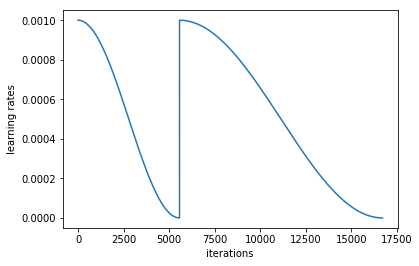

In [0]:
cosanneal.plot_lr()

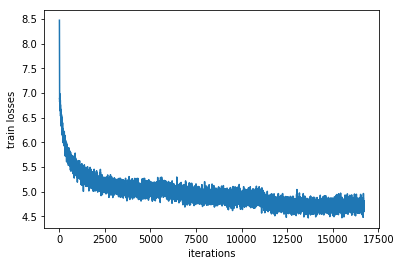

In [0]:
cosanneal.plot_loss()

### GRU

In [0]:
vocab_size = md.n
emb_nf = 200
nf = 256

In [0]:
class CharGRU(nn.Module):
  def __init__(self, vocab_size, emb_nf, nf, nl=1):
    super().__init__()
    self.vocab_size = vocab_size
    self.emb = nn.Embedding(vocab_size, emb_nf)
    self.i_h = nn.Linear(emb_nf, nf)
    self.gru = nn.GRU(nf, nf, nl)
    self.h_o = nn.Linear(nf, vocab_size)
    self.h = torch.zeros(nl, bs, nf).cuda()
    self.tanh = nn.Tanh()
    self.nl = nl
    
  def forward(self, x):
    if x.size(1) != bs: self.h = torch.zeros(self.nl, x.size(1), nf).cuda()
    x = self.tanh(self.i_h(self.emb(x)))
    o, h = self.gru(x, self.h)
    self.h = h.detach()
    return F.log_softmax(self.h_o(o), -1).view(-1, self.vocab_size)

In [0]:
m = CharGRU(vocab_size, emb_nf, nf, nl=1).cuda()
opt = optim.Adam(m.parameters(), lr=lr)
cosanneal = CosAnneal(opt, len(md.trn_dl), cycle_len=cycle_len, cycle_mult=cycle_mult)

In [0]:
fit(m, md, epochs, opt, F.nll_loss, callbacks=[cosanneal])

  0%|          | 0/5568 [00:00<?, ?it/s]


    
epoch      trn_loss   val_loss  

       0        4.988159   4.986883  


  0%|          | 0/5568 [00:00<?, ?it/s]


       1        4.589925   4.72959   



       1        4.612802   4.672755  



### weight-dropped LSTM

In [0]:
def get_dropout_mask(x, p=0.1):
  return x.new_zeros((1, *x.size()[1:]), requires_grad=False).bernoulli_(1 - p) / (1 - p)

def detach_tensor(t):
  return t.detach() if isinstance(t, torch.Tensor) else [detach_tensor(o) for o in t]


class WeightDrop(torch.nn.Module):
    def __init__(self, module, dropout, weights=['weight_hh_l0']):
        super().__init__()
        self.module,self.weights,self.dropout = module,weights,dropout
        self._setup()

    def _setup(self):
        if isinstance(self.module, torch.nn.RNNBase): self.module.flatten_parameters = noop
        for name_w in self.weights:
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            if hasattr(self.module, name_w):
                delattr(self.module, name_w)
            setattr(self.module, name_w, w)
            
    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)


class VariationalDropout(nn.Module):
  def __init__(self, p=0.3):
    super().__init__()
    self.p = p
  
  def forward(self, x):
    mask = get_dropout_mask(x, self.p)
    return x * mask


class EmbeddingDropout(nn.Module):
  def __init__(self, emb):
    super().__init__()
    self.emb = emb
    
  def forward(self, x, p=0.1):
    mask = get_dropout_mask(self.emb.weight, p)
    w_dropped = self.emb.weight * mask
    return F.embedding(x, w_dropped, self.emb.padding_idx, self.emb.max_norm, \
                       self.emb.max_norm, self.emb.scale_grad_by_freq, self.emb.sparse)


class WDEncoder(nn.Module):
  def __init__(self, bs, vocab_sz, emb_sz, pad_idx, hid, layers, in_drop=0.4, \
               hh_drop=0.3, emb_drop=0.1, w_drop=0.5, emb_weights=None, bidir=False):
    super().__init__()
    self.dirs = 2 if bidir else 1
    self.bs, self.vocab_sz, self.emb_sz, self.hid, self.layers = bs, vocab_sz, emb_sz, hid, layers
    self.emb_drop = emb_drop
    self.emb = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_idx)
    self.dropped_emb = EmbeddingDropout(self.emb)
    self.dropped_in = VariationalDropout(in_drop)
    self.lstms = [nn.LSTM(emb_sz if n == 0 else hid, hid if n != layers - 1 else emb_sz, \
                          1, bidirectional=bidir) for n in range(layers)]
    self.wd_lstms = nn.ModuleList([WeightDrop(o, w_drop) for o in self.lstms])
    self.dropped_hh = nn.ModuleList([VariationalDropout(hh_drop) for n in range(layers)])
#     self.emb.weight.data.uniform_(-emb_initrange, emb_initrange)
    if emb_weights is not None:
      self.emb.weight = nn.Parameter(torch.Tensor(emb_weights))
      self.dropped_emb.emb.weight = nn.Parameter(torch.Tensor(emb_weights))

  def forward(self, x):
    sl, bs = x.size()
    if self.bs != bs:
      self.bs = bs
      self.reset()
    raw_output = self.dropped_in(self.dropped_emb(x, self.emb_drop))
    raw_outputs, outputs, hs = [], [], []
    for i, (lstm, drop) in enumerate(zip(self.wd_lstms, self.dropped_hh)):
#       pdb.set_trace()
      with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        raw_output, new_h = lstm(raw_output, self.h[i])
      raw_outputs.append(raw_output)
      if i < self.layers - 1: raw_output = drop(raw_output)
      outputs.append(raw_output)
      hs.append(new_h)
    self.h = detach_tensor(hs)
    return raw_outputs, outputs
  
  def new_h(self, nl):
    nf = self.hid if nl < self.layers - 1 else self.emb_sz
    return torch.zeros(1, self.bs, nf).cuda()#.data.uniform_(-initrange, initrange)
  
  def reset(self):
    self.h = [(self.new_h(i), self.new_h(i)) for i in range(self.layers)]
    
    
class WDDecoder(nn.Module):
  def __init__(self, vocab_sz, emb_sz, tie_encoder, out_drop=0.4):
    super().__init__()
    self.decoder = nn.Linear(emb_sz, vocab_sz, bias=False)
    self.drop = VariationalDropout(out_drop)
    self.decoder.weight = tie_encoder.weight

  def forward(self, args):
    raw_outputs, outputs = args
    x = self.drop(outputs[-1])
    sl, bs, nf = x.size()
    preds = self.decoder(x.view(sl * bs, nf))
    return preds.view(-1, preds.size(1))


class RNNSequential(nn.Sequential):
  def reset(self):
#     pdb.set_trace()
    for o in self.children():
      if hasattr(o, 'reset'):
        o.reset()


def WDLSTM(bs, vocab_sz, emb_sz, pad_idx, hid, layers, ps, emb_weights=None):
  if not isinstance(ps, collections.Iterable): ps = [ps] * 5
  in_drop, hh_drop, out_drop, emb_drop, w_drop = ps
  encoder = WDEncoder(bs, vocab_sz, emb_sz, pad_idx, hid, layers, in_drop, \
                      hh_drop, emb_drop, w_drop, emb_weights=emb_weights)
  return RNNSequential(encoder, WDDecoder(vocab_sz, emb_sz, encoder.emb, out_drop))

In [0]:
vocab_sz = md.n
pad_idx = stoi['_pad_']
emb_sz = 200
nf = 500
nl = 3
clip = 0.25
emb_initrange = 0.1
initrange = 1 / np.sqrt(nf)
ps = np.array([0.05, 0.05, 0.05, 0.02, 0.1]) * 1

In [0]:
lr = 3e-3
cycle_len = 1
cycle_mult = 2
epochs = 3
epochs = [cycle_len * cycle_mult**i for i, _ in enumerate(range(epochs))]

m = WDLSTM(bs, vocab_sz, emb_sz, pad_idx, nf, nl, ps).cuda()
opt = optim.Adam(m.parameters(), lr=lr, betas=(0.75, 0.99))
cosanneal = CosAnneal(opt, len(md.trn_dl), cycle_len=cycle_len, cycle_mult=cycle_mult)

In [0]:
def accuracy(outputs, targs):
  preds = torch.max(outputs, 1)[1]
  return (preds == targs).float().mean()


def loss_f(outputs, targs, crit_fn=F.cross_entropy):
  return crit_fn(outputs[0], targs)

In [0]:
fit(m, md, epochs, opt, F.cross_entropy, clip=clip, callbacks=[cosanneal], metrics=[accuracy])

     epoch      trn_loss   val_loss   accuracy  
       0        4.882206   4.794618   0.239594  
       1        4.812892   4.651131   0.247563  
       1        4.529045   4.584595   0.254397  
       2        4.523168   4.593299   0.250682  
       2        4.562455   4.524473   0.256603  
       2        4.374611   4.481817   0.261064  
       2        4.486718   4.47125    0.262309  



In [0]:
def get_fpath(fname):
  os.makedirs(PATH/'models', exist_ok=True)
  return PATH/f'models/{fname}.h5'

def save_model(fname, m):
  torch.save(m.state_dict(), get_fpath(fname))
  
def load_model(fname, m):
  sd = torch.load(get_fpath('sgdr_3cycle'), map_location=lambda storage, loc: storage)
  m_sd = set(m.state_dict().keys())
  for n in list(sd.keys()):
    if n not in m_sd and n+'_raw' in m_sd:
      if n + '_raw' not in sd: sd[n+'_raw'] = sd[n]
      del sd[n]
  m.load_state_dict(sd)

In [0]:
save_model('sgdr_3cycle', m)

### Test

In [0]:
def get_next(m, s:list):
  d = torch.unsqueeze(torch.Tensor(s), 1).long().cuda()
  preds = m(d)
  return preds.max(1)[1][-1].item()

def get_nexts(m, s, nl, sentences=1):
  c = 0
  dot_idx = stoi['.']
  m.eval()
  s = [stoi[o] for o in Tokenizer.tokenize_mp(s)[0]]
  out = []
  for i in range(nl):
    v = get_next(m, s)
    s.append(v)
    out.append(v)
    if v == dot_idx:
      c += 1
      if c >= sentences: break
  return out

def keep_writing(m, s, nl=500, sentences=1):
  newline_idx = stoi['\n']
  s += '.'
  ss = [o.strip() + '.' for o in re.split(r'\.|\?', s) if o != '']
  res = sum([get_nexts(m, o, nl, sentences) + [newline_idx] for o in ss], [])
  return ' '.join(itos[o] for o in res)  

In [0]:
s = 'It\'s not a movie, it\'s a video comedy. A lot of trash and a lot of humor.'
res = keep_writing(m, s)
print("> ", s)
print("Bot: ", res)

I:  It's not a movie, it's a video comedy. A lot of trash and a lot of humor.
Bot:  
 i 'm sure you will be disappointed . 
 
 the only thing that i did n't like was the fact that the movie was n't funny . 



In [0]:
s = 'The ending is unexpected, shen teng, huang jingyu and Yin zheng are all very good.'
res = keep_writing(m, s)
print("I: ", s)
print("Bot: ", res)

I:  The ending is unexpected, shen teng, huang jingyu and Yin zheng are all very good.
Bot:  i would recommend this to anyone who has a great time watching it . 



In [0]:
s = 'God is really the reversal of the goose bumps'
res = keep_writing(m, s, sentences=2)
print("I: ", s)
print("Bot: ", res)

I:  God is really the reversal of the goose bumps
Bot:  i think that the movie is a bit too long , but it is a very good movie . i have to say that i was surprised to see that this movie was made in the same vein as " the blair witch project " . 



### Fasttext

In [0]:
# !cd {PATH} && wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz && gunzip cc.en.300.vec.gz
!cd {PATH} && wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz && gunzip cc.en.300.bin.gz

In [0]:
# read weights from *.bin
!pip install git+https://github.com/facebookresearch/fastText.git
import fastText as ft

def ft_load_vectors(fname):
  emb_w = np.random.randn(len(itos), 300)
  ft_vecs = ft.load_model(str((PATH/fname)))
  vec_dict = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
  vec_matrix = np.stack(list(vec_dict.values()))
  mean_vec = vec_matrix.mean(0)
  for i, o in enumerate(itos):
    if o in vec_dict: emb_w[i] = vec_dict[o]
    else: emb_w[i] = mean_vec
  return emb_w

In [0]:
# # read weights from *.txt
# def ft_load_vectors(fname):
#   emb_w = np.random.randn(len(itos), 300)
#   with open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') as fp:
#     c, nr_tks = 0, len(itos) - 3
#     n, d = fp.readline().split()  # header
#     for line in fp:
#       tokens = line.rstrip().split(' ')
#       if tokens[0] in itos:
#         emb_w[stoi[tokens[0]]] = np.array([eval(o) for o in tokens[1:]])
#         c += 1
#         if c >= nr_tks: break
#   return emb_w

In [0]:
emb_w = ft_load_vectors(PATH/'cc.en.300.bin')
# emb_w = ft_load_vectors(PATH/'cc.en.300.vec')
np.save(PATH/'ft_emb_weights.npy', emb_w)

In [0]:
vocab_sz = md.n
pad_idx = stoi['_pad_']
emb_sz = 300
nf = 500
nl = 3
clip = 0.3
ps = np.array([0.05, 0.05, 0.05, 0.02, 0.1]) * 1

lr = 3e-3
cycle_len = 1
cycle_mult = 2
epochs = 3
epochs = [cycle_len * cycle_mult**i for i, _ in enumerate(range(epochs))]

m = WDLSTM(bs, vocab_sz, emb_sz, pad_idx, nf, nl, ps, emb_weights=emb_w).cuda()
opt = optim.Adam(m.parameters(), lr=lr, betas=(0.7, 0.99))
cosanneal = CosAnneal(opt, len(md.trn_dl), cycle_len=cycle_len, cycle_mult=cycle_mult)

In [0]:
fit(m, md, epochs, opt, F.cross_entropy, clip=clip, callbacks=[cosanneal], metrics=[accuracy])

     epoch      trn_loss   val_loss   accuracy  
       0        4.579641   4.529013   0.252729  
       1        4.548646   4.438005   0.260425  
       1        4.379018   4.365056   0.267696  
       2        4.414107   4.4228     0.261393  
       2        4.526043   4.361377   0.267618  
       2        4.145617   4.318527   0.272548  
       2        4.295489   4.305556   0.273613  



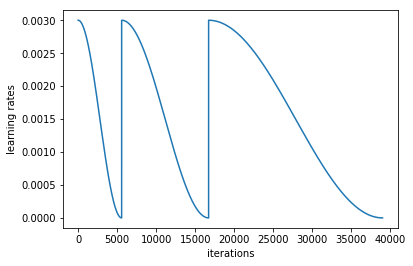

In [0]:
cosanneal.plot_lr()

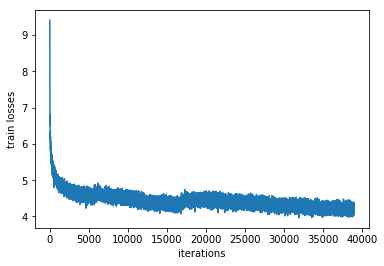

In [0]:
cosanneal.plot_loss()

In [0]:
save_model('sgdr_ft_3cycle', m)